In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2025-01-11 13:50:09--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  41.5MB/s    in 2.5s    

2025-01-11 13:50:12 (41.5 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# # Transformação para converter a imagem para tensor
# transform = transforms.Compose([
#     transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
#     transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
# ])

# # Criando o dataset
# mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [6]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [7]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [25]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_hidden_neurons=64):
        super(CNN, self).__init__()
        #self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, num_hidden_neurons)
        self.fc2 = nn.Linear(num_hidden_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [9]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 15.49it/s]


Epoch 1, Train Loss: 2.269, Train Accuracy: 16.10%
Epoch 1, Val Loss: 2.129, Val Accuracy: 23.60%


100%|██████████| 16/16 [00:00<00:00, 32.30it/s]


Epoch 2, Train Loss: 1.860, Train Accuracy: 36.50%
Epoch 2, Val Loss: 1.431, Val Accuracy: 51.40%


100%|██████████| 16/16 [00:00<00:00, 30.61it/s]


Epoch 3, Train Loss: 1.184, Train Accuracy: 60.30%
Epoch 3, Val Loss: 0.753, Val Accuracy: 75.00%


100%|██████████| 16/16 [00:00<00:00, 30.93it/s]


Epoch 4, Train Loss: 0.696, Train Accuracy: 75.50%
Epoch 4, Val Loss: 0.447, Val Accuracy: 87.20%


100%|██████████| 16/16 [00:00<00:00, 31.44it/s]


Epoch 5, Train Loss: 0.527, Train Accuracy: 83.50%
Epoch 5, Val Loss: 0.402, Val Accuracy: 89.60%
Treinamento concluído


In [12]:
history

{'train_losses': [2.268563285470009,
  1.8596483543515205,
  1.1842647083103657,
  0.6958825271576643,
  0.5273925615474582],
 'val_losses': [2.1286356151103973,
  1.4305216073989868,
  0.7533402219414711,
  0.44681341573596,
  0.40178731828927994],
 'train_accuracies': [16.1, 36.5, 60.3, 75.5, 83.5],
 'val_accuracies': [23.6, 51.4, 75.0, 87.2, 89.6]}

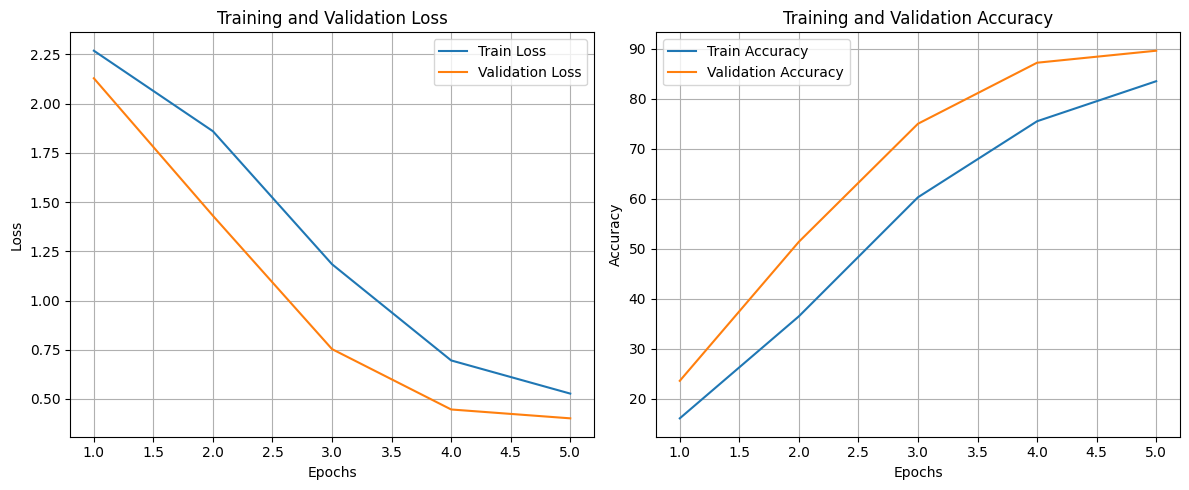

In [13]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_model(model, testloader)

Acurácia da rede na base de teste: 89.40%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [23]:
# Exercício 01

parameters_combination = [
    (2,4),
    (2,16),
    (8,4),
    (8,16),
]

for num_filters_1, num_filters_2 in parameters_combination:

    print(f'Número de filtros em num_filters_1 e num_filters_2: {num_filters_1} e {num_filters_2}')

    model_ex1 = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_filters_1=num_filters_1,
        num_filters_2=num_filters_2
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_ex1.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model_ex1,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model_ex1, testloader)
    print('\n')

Número de filtros em num_filters_1 e num_filters_2: 2 e 4


100%|██████████| 16/16 [00:00<00:00, 34.41it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 13.60%
Epoch 1, Val Loss: 2.160, Val Accuracy: 26.40%


100%|██████████| 16/16 [00:00<00:00, 35.27it/s]


Epoch 2, Train Loss: 2.062, Train Accuracy: 27.50%
Epoch 2, Val Loss: 1.656, Val Accuracy: 52.60%


100%|██████████| 16/16 [00:00<00:00, 32.94it/s]


Epoch 3, Train Loss: 1.382, Train Accuracy: 52.70%
Epoch 3, Val Loss: 0.878, Val Accuracy: 73.60%


100%|██████████| 16/16 [00:00<00:00, 34.58it/s]


Epoch 4, Train Loss: 0.892, Train Accuracy: 71.30%
Epoch 4, Val Loss: 0.603, Val Accuracy: 80.60%


100%|██████████| 16/16 [00:00<00:00, 33.88it/s]


Epoch 5, Train Loss: 0.667, Train Accuracy: 76.40%
Epoch 5, Val Loss: 0.472, Val Accuracy: 87.00%
Treinamento concluído
Acurácia da rede na base de teste: 86.40%


Número de filtros em num_filters_1 e num_filters_2: 2 e 16


100%|██████████| 16/16 [00:00<00:00, 30.57it/s]


Epoch 1, Train Loss: 2.285, Train Accuracy: 13.20%
Epoch 1, Val Loss: 2.238, Val Accuracy: 26.80%


100%|██████████| 16/16 [00:00<00:00, 31.75it/s]


Epoch 2, Train Loss: 2.141, Train Accuracy: 30.80%
Epoch 2, Val Loss: 1.960, Val Accuracy: 45.60%


100%|██████████| 16/16 [00:00<00:00, 32.94it/s]


Epoch 3, Train Loss: 1.588, Train Accuracy: 50.80%
Epoch 3, Val Loss: 0.997, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:00<00:00, 23.77it/s]


Epoch 4, Train Loss: 0.894, Train Accuracy: 67.70%
Epoch 4, Val Loss: 0.600, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 22.07it/s]


Epoch 5, Train Loss: 0.580, Train Accuracy: 80.80%
Epoch 5, Val Loss: 0.465, Val Accuracy: 85.60%
Treinamento concluído
Acurácia da rede na base de teste: 87.00%


Número de filtros em num_filters_1 e num_filters_2: 8 e 4


100%|██████████| 16/16 [00:00<00:00, 19.70it/s]


Epoch 1, Train Loss: 2.242, Train Accuracy: 19.90%
Epoch 1, Val Loss: 2.075, Val Accuracy: 28.40%


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


Epoch 2, Train Loss: 1.834, Train Accuracy: 35.30%
Epoch 2, Val Loss: 1.409, Val Accuracy: 53.00%


100%|██████████| 16/16 [00:00<00:00, 32.34it/s]


Epoch 3, Train Loss: 1.221, Train Accuracy: 57.90%
Epoch 3, Val Loss: 0.895, Val Accuracy: 71.80%


100%|██████████| 16/16 [00:00<00:00, 31.06it/s]


Epoch 4, Train Loss: 0.894, Train Accuracy: 68.80%
Epoch 4, Val Loss: 0.696, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 31.25it/s]


Epoch 5, Train Loss: 0.671, Train Accuracy: 76.90%
Epoch 5, Val Loss: 0.586, Val Accuracy: 79.20%
Treinamento concluído
Acurácia da rede na base de teste: 79.00%


Número de filtros em num_filters_1 e num_filters_2: 8 e 16


100%|██████████| 16/16 [00:00<00:00, 30.27it/s]


Epoch 1, Train Loss: 2.264, Train Accuracy: 15.00%
Epoch 1, Val Loss: 2.163, Val Accuracy: 33.20%


100%|██████████| 16/16 [00:00<00:00, 29.66it/s]


Epoch 2, Train Loss: 1.992, Train Accuracy: 36.70%
Epoch 2, Val Loss: 1.642, Val Accuracy: 52.20%


100%|██████████| 16/16 [00:00<00:00, 29.74it/s]


Epoch 3, Train Loss: 1.298, Train Accuracy: 58.00%
Epoch 3, Val Loss: 0.773, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:00<00:00, 29.89it/s]


Epoch 4, Train Loss: 0.721, Train Accuracy: 75.10%
Epoch 4, Val Loss: 0.497, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 29.46it/s]


Epoch 5, Train Loss: 0.487, Train Accuracy: 82.50%
Epoch 5, Val Loss: 0.411, Val Accuracy: 87.20%
Treinamento concluído
Acurácia da rede na base de teste: 89.00%




### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [30]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)

    model_ex2 = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_hidden_neurons=num_neurons
    )

    #print (model_ex2)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_ex2.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model_ex2,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model_ex2, testloader)
    print(f'Número de neurônios na camada fully connected: {num_neurons}\n')

100%|██████████| 16/16 [00:00<00:00, 22.05it/s]


Epoch 1, Train Loss: 2.299, Train Accuracy: 14.00%
Epoch 1, Val Loss: 2.246, Val Accuracy: 24.00%


100%|██████████| 16/16 [00:00<00:00, 20.12it/s]


Epoch 2, Train Loss: 2.115, Train Accuracy: 28.30%
Epoch 2, Val Loss: 1.952, Val Accuracy: 33.40%


100%|██████████| 16/16 [00:00<00:00, 19.18it/s]


Epoch 3, Train Loss: 1.593, Train Accuracy: 50.70%
Epoch 3, Val Loss: 1.052, Val Accuracy: 70.60%


100%|██████████| 16/16 [00:00<00:00, 29.81it/s]


Epoch 4, Train Loss: 0.945, Train Accuracy: 67.20%
Epoch 4, Val Loss: 0.575, Val Accuracy: 82.80%


100%|██████████| 16/16 [00:00<00:00, 29.60it/s]


Epoch 5, Train Loss: 0.587, Train Accuracy: 79.60%
Epoch 5, Val Loss: 0.401, Val Accuracy: 88.40%
Treinamento concluído
Acurácia da rede na base de teste: 89.20%
Número de neurônios na camada fully connected: 58



100%|██████████| 16/16 [00:00<00:00, 30.20it/s]


Epoch 1, Train Loss: 2.270, Train Accuracy: 20.10%
Epoch 1, Val Loss: 2.129, Val Accuracy: 38.20%


100%|██████████| 16/16 [00:00<00:00, 29.56it/s]


Epoch 2, Train Loss: 1.876, Train Accuracy: 41.60%
Epoch 2, Val Loss: 1.372, Val Accuracy: 55.80%


100%|██████████| 16/16 [00:00<00:00, 30.39it/s]


Epoch 3, Train Loss: 1.213, Train Accuracy: 56.30%
Epoch 3, Val Loss: 0.880, Val Accuracy: 70.20%


100%|██████████| 16/16 [00:00<00:00, 30.53it/s]


Epoch 4, Train Loss: 0.890, Train Accuracy: 69.40%
Epoch 4, Val Loss: 0.660, Val Accuracy: 79.60%


100%|██████████| 16/16 [00:00<00:00, 29.95it/s]


Epoch 5, Train Loss: 0.635, Train Accuracy: 77.80%
Epoch 5, Val Loss: 0.519, Val Accuracy: 84.60%
Treinamento concluído
Acurácia da rede na base de teste: 85.40%
Número de neurônios na camada fully connected: 48



100%|██████████| 16/16 [00:00<00:00, 30.20it/s]


Epoch 1, Train Loss: 2.288, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.184, Val Accuracy: 35.80%


100%|██████████| 16/16 [00:00<00:00, 30.36it/s]


Epoch 2, Train Loss: 2.006, Train Accuracy: 43.10%
Epoch 2, Val Loss: 1.660, Val Accuracy: 61.40%


100%|██████████| 16/16 [00:00<00:00, 30.76it/s]


Epoch 3, Train Loss: 1.275, Train Accuracy: 59.60%
Epoch 3, Val Loss: 0.740, Val Accuracy: 79.00%


100%|██████████| 16/16 [00:00<00:00, 30.58it/s]


Epoch 4, Train Loss: 0.698, Train Accuracy: 76.50%
Epoch 4, Val Loss: 0.494, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:00<00:00, 29.81it/s]


Epoch 5, Train Loss: 0.465, Train Accuracy: 84.60%
Epoch 5, Val Loss: 0.443, Val Accuracy: 86.20%
Treinamento concluído
Acurácia da rede na base de teste: 89.60%
Número de neurônios na camada fully connected: 70



100%|██████████| 16/16 [00:00<00:00, 23.19it/s]


Epoch 1, Train Loss: 2.283, Train Accuracy: 16.00%
Epoch 1, Val Loss: 2.196, Val Accuracy: 18.00%


100%|██████████| 16/16 [00:00<00:00, 21.67it/s]


Epoch 2, Train Loss: 2.066, Train Accuracy: 28.60%
Epoch 2, Val Loss: 1.852, Val Accuracy: 35.40%


100%|██████████| 16/16 [00:00<00:00, 20.27it/s]


Epoch 3, Train Loss: 1.660, Train Accuracy: 41.50%
Epoch 3, Val Loss: 1.296, Val Accuracy: 61.00%


100%|██████████| 16/16 [00:00<00:00, 19.61it/s]


Epoch 4, Train Loss: 1.226, Train Accuracy: 59.20%
Epoch 4, Val Loss: 0.834, Val Accuracy: 73.80%


100%|██████████| 16/16 [00:00<00:00, 29.15it/s]


Epoch 5, Train Loss: 1.002, Train Accuracy: 65.30%
Epoch 5, Val Loss: 0.635, Val Accuracy: 81.40%
Treinamento concluído
Acurácia da rede na base de teste: 84.00%
Número de neurônios na camada fully connected: 19



100%|██████████| 16/16 [00:00<00:00, 31.66it/s]


Epoch 1, Train Loss: 2.282, Train Accuracy: 17.00%
Epoch 1, Val Loss: 2.152, Val Accuracy: 37.20%


100%|██████████| 16/16 [00:00<00:00, 29.44it/s]


Epoch 2, Train Loss: 1.971, Train Accuracy: 40.00%
Epoch 2, Val Loss: 1.606, Val Accuracy: 57.40%


100%|██████████| 16/16 [00:00<00:00, 28.01it/s]


Epoch 3, Train Loss: 1.339, Train Accuracy: 57.20%
Epoch 3, Val Loss: 0.823, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 31.32it/s]


Epoch 4, Train Loss: 0.831, Train Accuracy: 71.70%
Epoch 4, Val Loss: 0.556, Val Accuracy: 83.40%


100%|██████████| 16/16 [00:00<00:00, 31.64it/s]


Epoch 5, Train Loss: 0.589, Train Accuracy: 81.30%
Epoch 5, Val Loss: 0.469, Val Accuracy: 85.20%
Treinamento concluído
Acurácia da rede na base de teste: 85.80%
Número de neurônios na camada fully connected: 49

